In [2]:
from __future__ import print_function, division
import os
import torch
import json
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
import torch.optim as optim
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm
import urllib
from io import BytesIO
from PIL import Image
from torchvision import transforms, models
from torch.autograd import Variable
import time

PATH = '/home/vedder/code/data/imaterialist-challenge-furniture-2018'
IMAGES_TRAIN_PATH = f'{PATH}/train'
IMAGES_VALID_PATH = f'{PATH}/valid'
JSON_TRAIN_PATH = f'{PATH}/filtered_train.json'
JSON_VALID_PATH = f'{PATH}/filtered_valid.json'
BATCH_SIZE = 32
NET_SIZE = 512

In [3]:
df = pd.read_json(JSON_VALID_PATH)
splits = np.array_split(df, 512)

def download_image(row):
    url = row['images']['url'][0]
    image_id = row['images']['image_id']
    file_name = f"{IMAGES_VALID_PATH}/{image_id}.jpg"
    if not os.path.isfile(file_name): 
        file = BytesIO(urllib.request.urlopen(url).read())
        img = Image.open(file)
        img.convert('RGB')
        img.save(file_name)
        file.close()
        
def download_images(dataframe):
    for index, row in dataframe.iterrows():
    
        try:
            download_image(row)

        except Exception as error:
            print(error)

p = Pool(512)
p.map(download_images, splits)
    

In [4]:
# df = pd.read_json(f'{PATH}/train.json')

# def new_json_file(df):
#     new_df = pd.DataFrame(columns=df.columns)
#     for index, row in tqdm(df.iterrows()):
#         image_id = row['images']['image_id']
#         file_name = f"{IMAGES_TRAIN_PATH}/{image_id}.jpg"
#         try:
#             Image.open(file_name)
#             new_df = new_df.append(row, ignore_index=True)
#         except Exception as error:
#             print(error)
#     return new_df

# new_df = new_json_file(df)
# new_df.to_json(f'{PATH}/filtered_train.json')

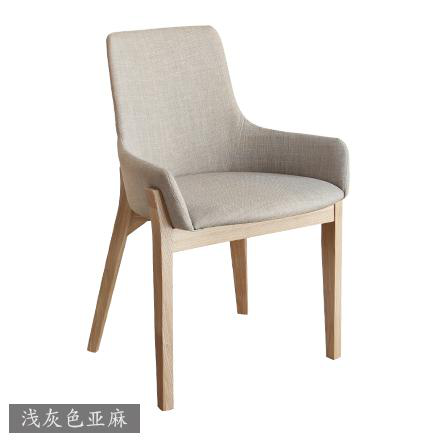

In [5]:
image_id = '12378'
file_name = f"{IMAGES_TRAIN_PATH}/{image_id}.jpg"
image = Image.open(file_name)
image

In [15]:
class IMaterialDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.transform = transform
        self.path = path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        entry = self.df.iloc[idx]['images']
        url = entry['url'][0]
        image_id = entry['image_id']
        file_name = f"{IMAGES_TRAIN_PATH}/{image_id}.jpg"
        image = Image.open(file_name)
        label_id = int(self.df.iloc[idx]['annotations']['label_id'])

        
        if self.transform:
            image = self.transform(image)
        
        return image, label_id
        

In [16]:
train_df = pd.read_json(JSON_TRAIN_PATH)
valid_df = pd.read_json(JSON_VALID_PATH)

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

data_transforms = transforms.Compose([
    transforms.Resize((NET_SIZE, NET_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

datasets = {
    'train': IMaterialDataset(train_df, IMAGES_TRAIN_PATH, data_transforms),
    'valid': IMaterialDataset(valid_df, IMAGES_VALID_PATH, data_transforms)
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        datasets[x], batch_size=32, shuffle=True, num_workers=4
    )
    for x in ['train', 'valid']
}

In [25]:
next(iter(dataloaders['train']))[1][-1]

28

In [18]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloaders['train'].dataset),
                     'valid': len(dataloaders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'training':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                print(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} '
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc,
                valid_epoch_loss, valid_epoch_acc))

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    torch.save(model, '{:4f}.pth'.format(best_acc))
    return model

In [26]:
model = models.resnet50(pretrained=True)
## allow for any input size
model.avgpool = nn.AdaptiveAvgPool2d(1)

for param in model.parameters():
    param.requires_grad = False
    
num_features = model.fc.in_features
# fc_layers = nn.Sequential(
#                 nn.Dropout(p=0.5),
#                 nn.Linear(num_features, 128)
#             )
model.fc = nn.Linear(num_features, 128)
model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# inputs = next(iter(dataloaders))
# outputs = model(inputs)
# _, preds = torch.max(outputs.data, 1)
# loss = criterion(outputs, labels)

new_model = train_model(dataloaders, model, criterion, optimizer, scheduler)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518243271935/work/torch/lib/THC/generic/THCTensorCopy.c:20